In [32]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet
import itertools
import numpy as np

# import sys
# sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')
# print(sys.path)


from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing, preprocess_lstm, prophet_preprocessing_one_station

from metro_app.ml_logic.model import train_prophet, predict_prophet


# Import data

In [26]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
mock_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
mock_df.head()


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_56235/4168347678.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


ds         y
0  2007-12-10  9.590761
1  2007-12-11  8.519590
2  2007-12-12  8.183677
3  2007-12-13  8.072467
4  2007-12-14  7.893572

# 1) Mock try

In [ ]:
m = Prophet()
m.fit(mock_df)


15:34:52 - cmdstanpy - INFO - Chain [1] start processing
15:34:53 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
future.head()


ds
0 2007-12-10
1 2007-12-11
2 2007-12-12
3 2007-12-13
4 2007-12-14

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.204239    7.540284    8.932394
3266 2017-01-16  8.529231    7.820480    9.282256
3267 2017-01-17  8.316611    7.709121    9.042063
3268 2017-01-18  8.149244    7.488673    8.889674
3269 2017-01-19  8.161142    7.467721    8.937606

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


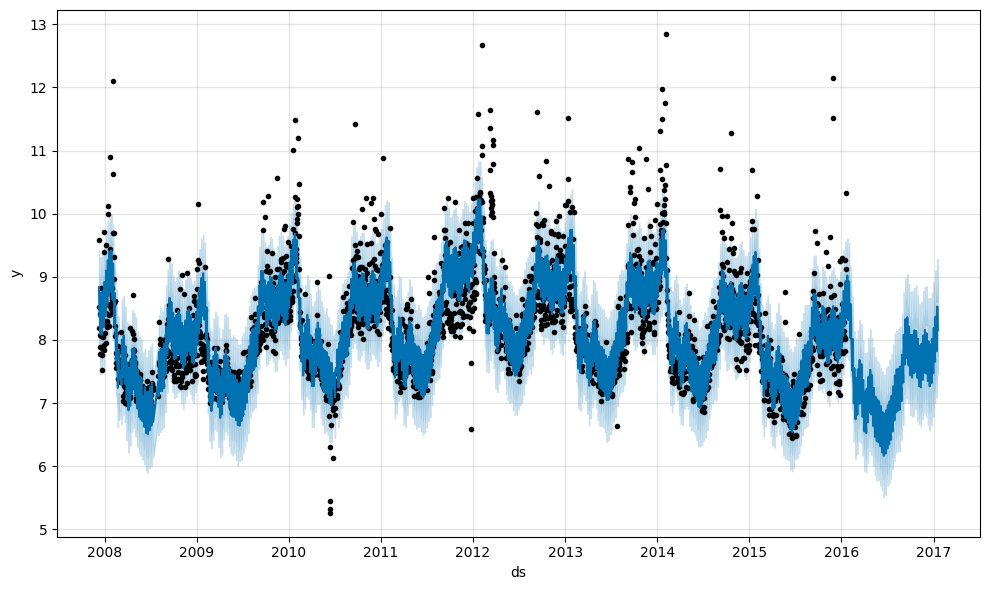

In [ ]:
fig1 = m.plot(forecast)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated,

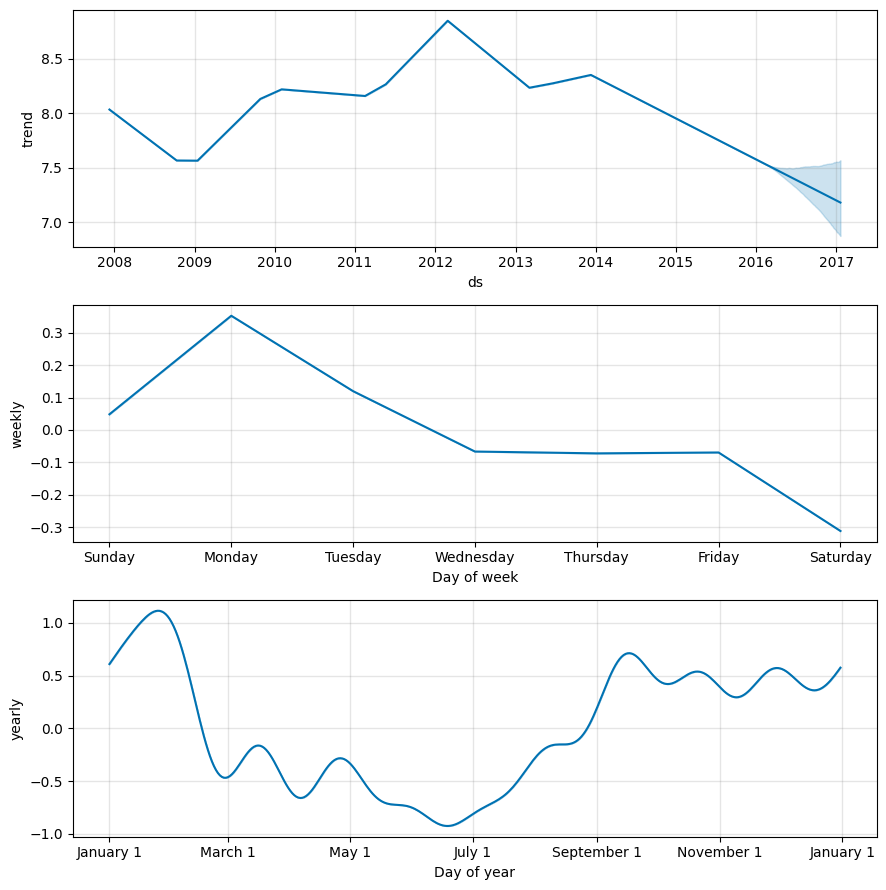

In [ ]:
fig2 = m.plot_components(forecast)


In [ ]:
plot_plotly(m, forecast)


In [ ]:
plot_components_plotly(m, forecast)


# 2) Essai Metro Seoul

## Preprocessing new method (Achasan 5 - Exit)

In [27]:
df_achasan5 = prophet_preprocessing_one_station(df=df, station_name="Achasan(Rear Entrance to Seoul Children's Grand Park)",
                                       metro_line=5, entry_exit='exit')


/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line'] = df['line'].astype('int')
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [20]:
m = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=3.0,
                holidays_prior_scale=0.02, seasonality_mode='multiplicative')

m.add_country_holidays(country_name='KR')

m.fit(df)


16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
prediction = predict_prophet(m, 2)


<Axes: xlabel='ds'>

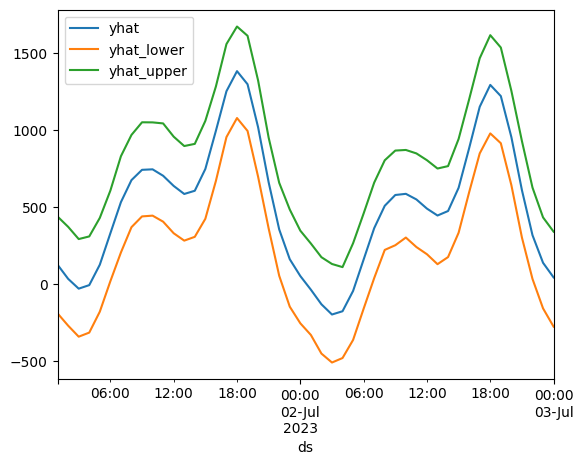

In [24]:
prediction.plot(x='ds')


## Station Achasan 5 - Exit

### preprocess

In [28]:
#split data test train
days = 2
# index = round(train_size*df_156.shape[0])
df_achasan5_train = df_achasan5.iloc[:-24*days]
df_achasan5_test = df_achasan5.iloc[-24*days:]


In [29]:
df_achasan5_train


ds      y
0     2020-01-01 01:00:00    0.0
1     2020-01-01 02:00:00    0.0
2     2020-01-01 03:00:00    0.0
3     2020-01-01 04:00:00    0.0
4     2020-01-01 05:00:00  239.0
...                   ...    ...
30595 2023-06-28 20:00:00  905.0
30596 2023-06-28 21:00:00  790.0
30597 2023-06-28 22:00:00  654.0
30598 2023-06-28 23:00:00  450.0
30599 2023-06-29 00:00:00    0.0

[30600 rows x 2 columns]

### Train predict

In [34]:
m = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=3.0,
                  holidays_prior_scale=0.02, seasonality_mode='multiplicative')

m.add_country_holidays(country_name='KR')

m.fit(df_achasan5_train)


16:46:50 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is depre

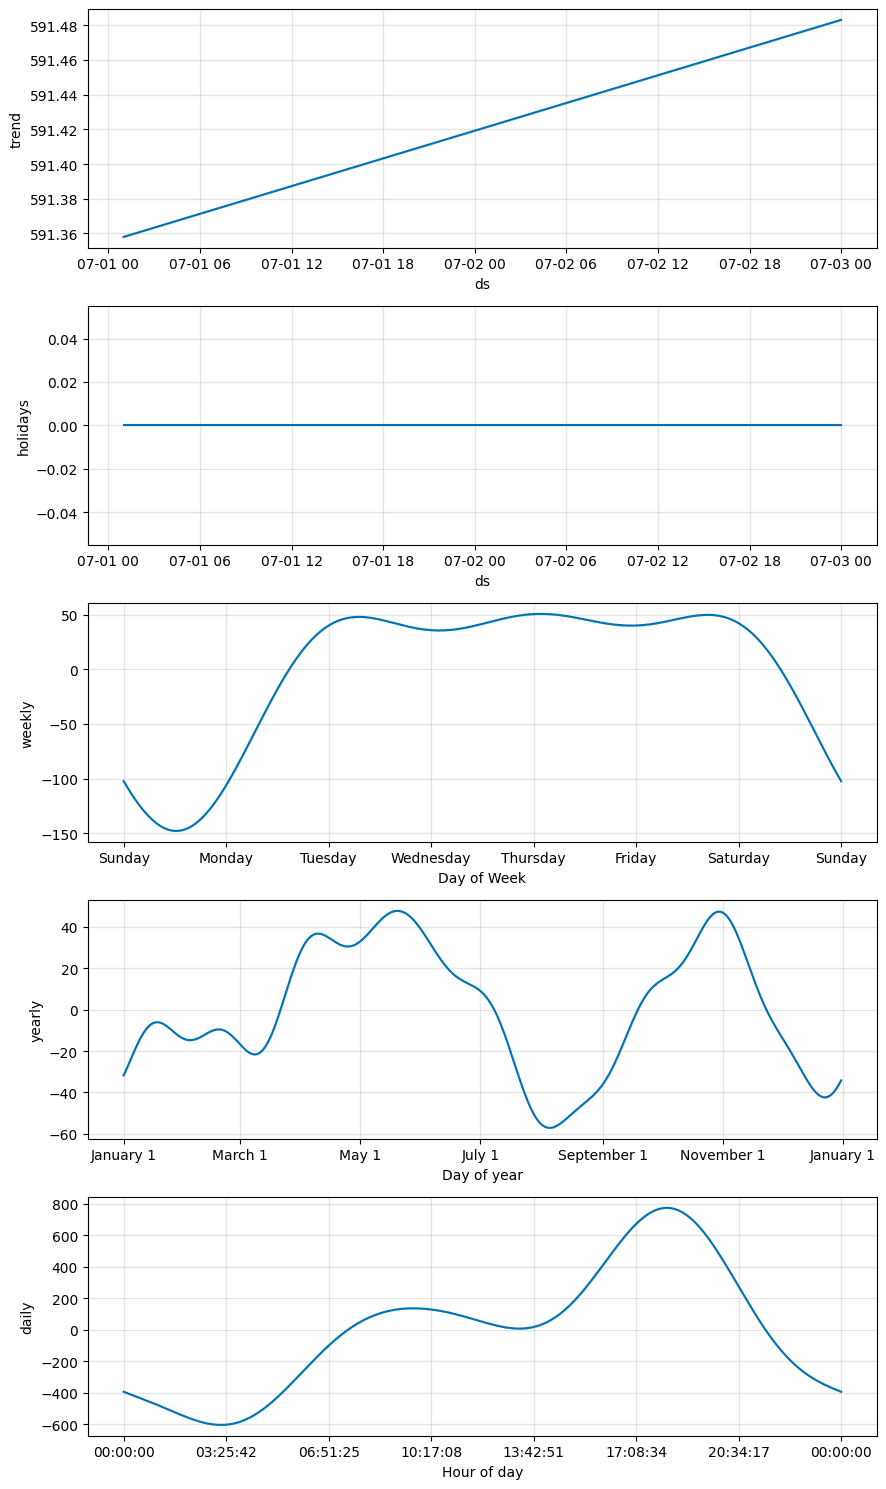

In [57]:
future = m.make_future_dataframe(periods=days*24, freq='h', include_history=False)

fig = m.plot_components(m.predict(future))


In [35]:
prediction = predict_prophet(m, 2)


<Axes: xlabel='ds'>

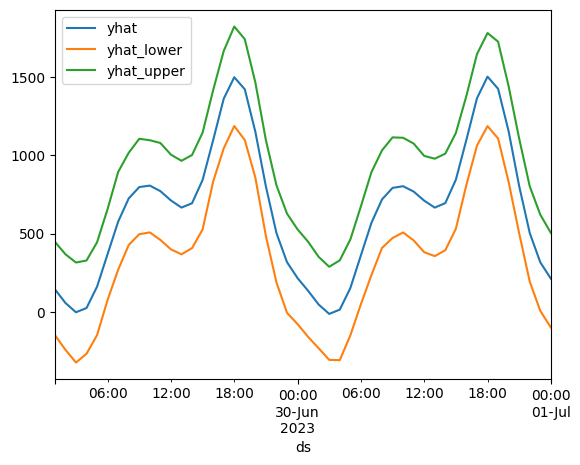

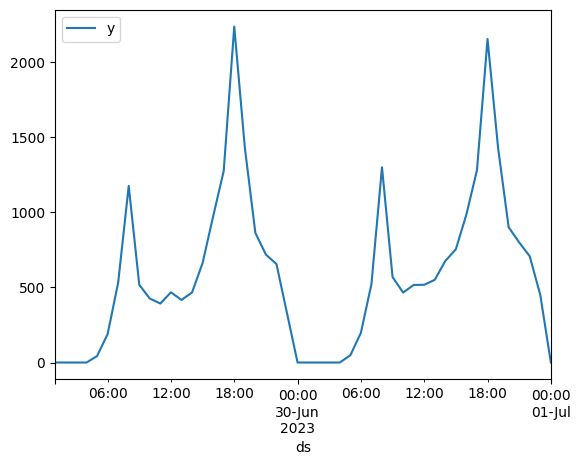

In [37]:
prediction.plot(x='ds')
df_achasan5_test.plot(x='ds')


### Cross Validation


In [50]:
df_cv = cross_validation(m, initial= '400 days', period='50 days', horizon = '2 days')


  0%|          | 0/4 [00:00<?, ?it/s]

17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:29 - cmdstanpy - INFO - Chain [1] done processing
17:15:31 - cmdstanpy - INFO - Chain [1] start processing
17:15:32 - cmdstanpy - INFO - Chain [1] done processing
17:15:33 - cmdstanpy - INFO - Chain [1] start processing
17:15:35 - cmdstanpy - INFO - Chain [1] done processing
17:15:37 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
df_cv[['ds','yhat','y']].head(20)


ds         yhat       y
0  2022-04-03 01:00:00   -34.742873     0.0
1  2022-04-03 02:00:00  -116.047219     0.0
2  2022-04-03 03:00:00  -173.191977     0.0
3  2022-04-03 04:00:00  -154.656883     0.0
4  2022-04-03 05:00:00   -41.825803    42.0
5  2022-04-03 06:00:00   130.045336    89.0
6  2022-04-03 07:00:00   299.210336   129.0
7  2022-04-03 08:00:00   421.178356   344.0
8  2022-04-03 09:00:00   487.040439   883.0
9  2022-04-03 10:00:00   507.428839  1093.0
10 2022-04-03 11:00:00   490.562804  1198.0
11 2022-04-03 12:00:00   444.472603  1052.0
12 2022-04-03 13:00:00   399.136476  1192.0
13 2022-04-03 14:00:00   413.489507   854.0
14 2022-04-03 15:00:00   542.022319   757.0
15 2022-04-03 16:00:00   779.788978   740.0
16 2022-04-03 17:00:00  1037.735744   739.0
17 2022-04-03 18:00:00  1183.666734   764.0
18 2022-04-03 19:00:00  1127.506285   544.0
19 2022-04-03 20:00:00   884.889111   455.0

#### Performance metrics

In [52]:
df_p = performance_metrics(df_cv)
df_p.head(10)
np.mean(df_p['mae'])


184.93777076269828

In [53]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.01],
    'seasonality_prior_scale': [0.1, 1.0, 3.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.fit(df_achasan5)
    df_cv = cross_validation(m, initial='499 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


17:19:07 - cmdstanpy - INFO - Chain [1] start processing
17:19:08 - cmdstanpy - INFO - Chain [1] done processing
17:19:11 - cmdstanpy - INFO - Chain [1] start processing
17:19:11 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:13 - cmdstanpy - INFO - Chain [1] start processing
17:19:14 - cmdstanpy - INFO - Chain [1] done processing
17:19:14 - cmdstanpy - INFO - Chain [1] done processing
17:19:15 - cmdstanpy - INFO - Chain [1] done processing
17:19:15 - cmdstanpy - INFO - Chain [1] done processing
17:19:15 - cmdstanpy - INFO - Chain [1] done processing
17:19:16 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale        rmse
0                     0.001                      0.1  244.186990
1                     0.001                      1.0  244.230277
2                     0.001                      3.0  244.103233
3                     0.001                     10.0  244.256538
4                     0.002                      0.1  243.953172
5                     0.002                      1.0  243.963170
6                     0.002                      3.0  243.971837
7                     0.002                     10.0  243.859387
8                     0.010                      0.1  243.051556
9                     0.010                      1.0  243.169207
10                    0.010                      3.0  242.991243
11                    0.010                     10.0  243.082246


17:21:38 - cmdstanpy - INFO - Chain [1] done processing


### Hyperparameter Tuning

In [127]:
df_156_short.reset_index(inplace=True)


In [150]:
param_grid = {
    'changepoint_prior_scale': [0.002, 0.003],
    'seasonality_prior_scale': [2.0, 3.0],
    'holidays_prior_scale' : [0.02, 0.03],
    'seasonality_mode' : ['multiplicative']
}

cutoffs = pd.to_datetime(['2022-09-20', '2022-12-10', '2023-03-29'])


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.fit(df_156_short)
    df_cv = cross_validation(m, initial='499 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


12:56:57 - cmdstanpy - INFO - Chain [1] start processing
12:56:57 - cmdstanpy - INFO - Chain [1] done processing
12:56:58 - cmdstanpy - INFO - Chain [1] start processing
12:56:58 - cmdstanpy - INFO - Chain [1] done processing
12:56:59 - cmdstanpy - INFO - Chain [1] start processing
12:56:59 - cmdstanpy - INFO - Chain [1] done processing
12:57:00 - cmdstanpy - INFO - Chain [1] start processing
12:57:01 - cmdstanpy - INFO - Chain [1] done processing
12:57:01 - cmdstanpy - INFO - Chain [1] start processing
12:57:02 - cmdstanpy - INFO - Chain [1] done processing
12:57:03 - cmdstanpy - INFO - Chain [1] start processing
12:57:03 - cmdstanpy - INFO - Chain [1] done processing
12:57:04 - cmdstanpy - INFO - Chain [1] start processing
12:57:04 - cmdstanpy - INFO - Chain [1] done processing
12:57:05 - cmdstanpy - INFO - Chain [1] start processing
12:57:05 - cmdstanpy - INFO - Chain [1] done processing
12:57:06 - cmdstanpy - INFO - Chain [1] start processing
12:57:06 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.002                      2.0                  0.02   
1                     0.002                      2.0                  0.02   
2                     0.002                      2.0                  0.03   
3                     0.002                      2.0                  0.03   
4                     0.002                      3.0                  0.02   
5                     0.002                      3.0                  0.02   
6                     0.002                      3.0                  0.03   
7                     0.002                      3.0                  0.03   
8                     0.003                      2.0                  0.02   
9                     0.003                      2.0                  0.02   
10                    0.003                      2.0                  0.03   
11                    0.003                      2.0            

12:57:32 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
tuning_results.iloc[rmses.index(min(rmses))]


changepoint_prior_scale             0.002
seasonality_prior_scale               3.0
holidays_prior_scale                 0.02
seasonality_mode           multiplicative
rmse                           240.063768
Name: 4, dtype: object

In [54]:
best_params = all_params[np.argmin(rmses)]
print(best_params)


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 3.0}


### Fit

In [153]:
#trying with the params of the grid search
m_tuned = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=3.0,
                  holidays_prior_scale=0.02, seasonality_mode='multiplicative')
m_tuned.add_country_holidays(country_name='KR')
m_tuned.fit(df_156_short)


12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:57 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future = m.make_future_dataframe(periods=200, freq='h', include_history=False)
future


ds
0   2023-03-01 08:00:00
1   2023-03-01 09:00:00
2   2023-03-01 10:00:00
3   2023-03-01 11:00:00
4   2023-03-01 12:00:00
..                  ...
195 2023-03-09 11:00:00
196 2023-03-09 12:00:00
197 2023-03-09 13:00:00
198 2023-03-09 14:00:00
199 2023-03-09 15:00:00

[200 rows x 1 columns]

In [155]:
forecast_tuned = m_tuned.predict(future)
forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


ds        yhat  yhat_lower   yhat_upper
190 2023-03-09 06:00:00  570.396311  249.964368   881.843290
191 2023-03-09 07:00:00  735.396446  428.342383  1045.648809
192 2023-03-09 08:00:00  791.958568  478.554251  1096.795750
193 2023-03-09 09:00:00  783.226276  445.650041  1082.860534
194 2023-03-09 10:00:00  762.570177  456.928645  1062.976646
195 2023-03-09 11:00:00  747.596659  406.681683  1065.992870
196 2023-03-09 12:00:00  733.108552  433.157518  1049.979694
197 2023-03-09 13:00:00  736.399076  420.372531  1050.649584
198 2023-03-09 14:00:00  809.329319  496.621291  1113.647231
199 2023-03-09 15:00:00  988.522997  679.371827  1310.140042

In [87]:
df_156_test['y'].head(10)


ds
2023-03-01 08:00:00    324
2023-03-01 09:00:00    433
2023-03-01 10:00:00    477
2023-03-01 11:00:00    604
2023-03-01 12:00:00    667
2023-03-01 13:00:00    694
2023-03-01 14:00:00    717
2023-03-01 15:00:00    704
2023-03-01 16:00:00    822
2023-03-01 17:00:00    672
Name: y, dtype: int64

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



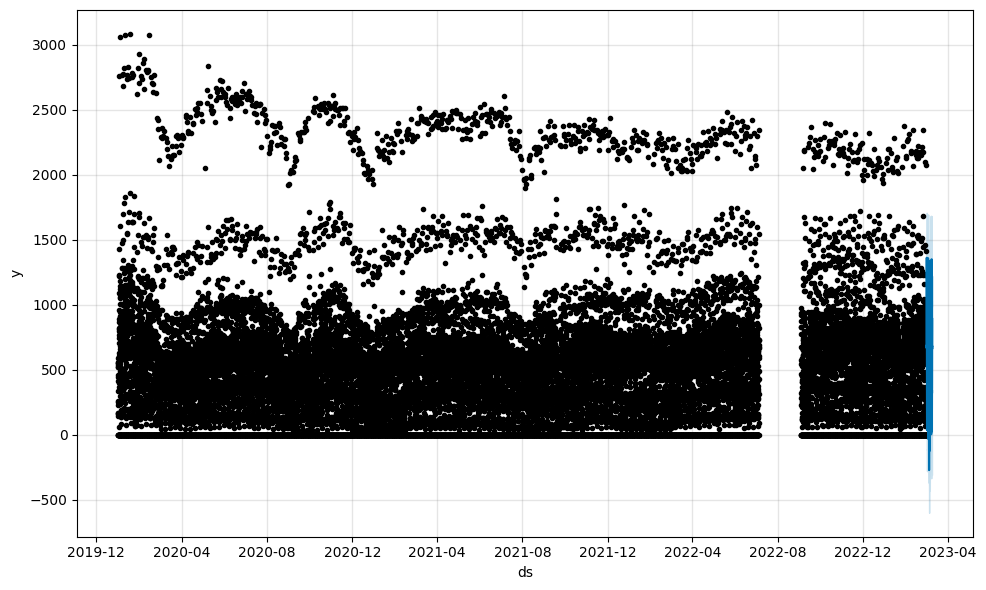

In [88]:
fig1 = m.plot(forecast)


/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:397: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/thomas_metral/.pyenv/versions/3.10.6/envs/metro_seoul/lib/python3.10/site-packages/prophet/plot.py:401: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarra

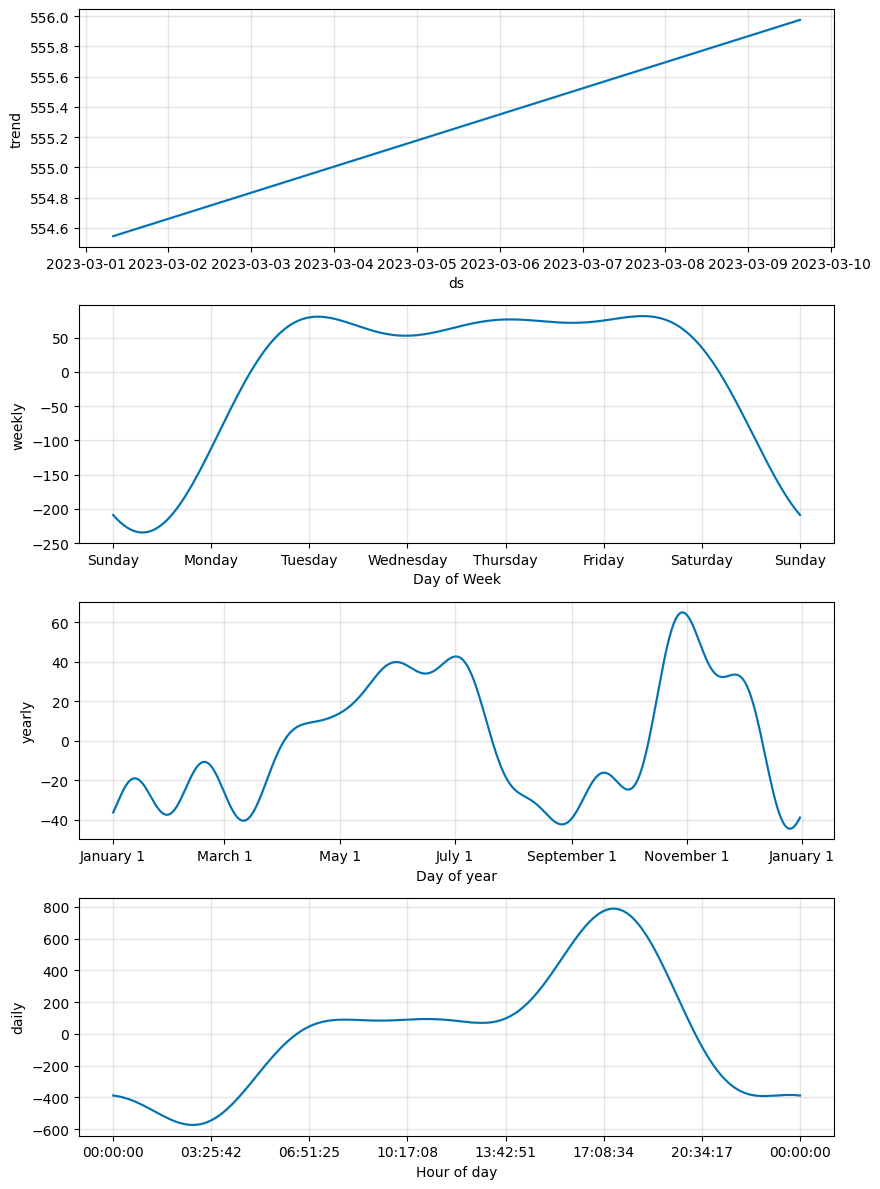

In [89]:
fig2 = m.plot_components(forecast)


In [90]:
plot_plotly(m, forecast)


In [91]:
plot_components_plotly(m, forecast)
